In [9]:
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.size'] = 12



In [10]:
url = 'https://www.shine.com/job-search/jobs?job_type=2&top_companies_boost=true&sort=1'
response = requests.get(url)
print('The response that we got back from the URL is', response.status_code)


The response that we got back from the URL is 200


In [11]:
soup = BeautifulSoup(response.text,'html.parser')
html = soup.find_all('div')


In [12]:
req = soup.select('div h2[itemprop="name"]')
#fetching the text from the html
titles = [r.text for r in req]
#Removing any spaces
titles = [t.replace("  ", "") for t in titles]
titles[:5]

['Recruiter Excutive',
 'Customer Support Representative',
 'Telesales Executive',
 'Financial Advisor',
 'Customer Sales Representative']

In [13]:
orgs = soup.find_all('div', class_='jobCard_jobCard_cName__mYnow')
#fetching the text from the HTML
orgs1 = [o.text for o in orgs]
sub_string ='Hiring'
#Splitting the string on a sub string and getting the first index (Cleaning up names)
orgs1 = [o.split(sub_string)[0] for o in orgs1]
#Removing any spaces
orgs1 = [o.strip() for o in orgs1]

In [14]:
#fetching the HTML data from the class where the location data is available
loc = soup.find_all('div', class_='jobCard_jobCard_lists__fdnsc')
#fetching all the text from the HTML
location = [l.text for l in loc]
#cleaning the locations (Getting everything after the Yr(s))
location = [re.findall("Yrs?(.*)$", i)[0] for i in location]
#Getting rid of unnecessary text
location = [l.replace("+4", ", ") for l in location]

location[:5]

['Pune', 'Noida+2Gurugram, Delhi', 'Thane', 'Mumbai City', 'Delhi']

In [15]:
#fetching the text from the loc variable for the experience
exp = [l.text for l in loc]
#Cleaning up using regex
experience = [re.findall("^(.*) Yrs?", i)[0] for i in exp]

experience[:5]

['1 to 2', '0 to 1', '1 to 6', '0 to 4', '1']

In [18]:
#Fetching number of positions
vac = soup.find_all('ul', class_='jobCard_jobCard_jobDetail__jD82J')
#fetching the text from the HTML
vac = [v.text for v in vac ]

vac[:5]

['Regular2 Positions',
 'Regular60 Positions',
 'Regular10 Positions',
 'Regular30 Positions',
 'Regular7 Positions']

In [20]:
#Cleaning up the data
vacancies = [int(re.findall(r'\d+', text)[0]) if re.findall(r'\d+', text) else 1 for text in vac]

#for text in vac - fetches each element in the list
#int(re.findall(r'\d+', text)[0]) - get the first element and convert that number to interger
#if re.findall(r'\d+', text) else 1 - it checks if the element at an index is blank, if 'yes' the value will default to 1


In [22]:
#putting the pieces together
data = {'Titles':titles, 'Firm Name': orgs1, 
        'Job Location':location, 'Experience':experience,
        'Positions': vacancies}
df = pd.DataFrame(data)

In [23]:
#Checking for duplicates based on the titles column (you can pick any other column of your choice)
df['Titles'].duplicated().sum()

1

In [24]:
#Dropping duplicates
df.drop_duplicates(subset='Titles', inplace=True)

In [25]:
#checking to see if those duplicates have been dropped or not
df['Titles'].duplicated().sum()

0

In [26]:
df.head()

,Titles,Firm Name,Job Location,Experience,Positions
0,Recruiter Excutive,AASAANJOBS PRIVATE LIMITED,Pune,1 to 2,2
1,Customer Support Representative,THE CAREER NEXT.,"Noida+2Gurugram, Delhi",0 to 1,60
2,Telesales Executive,Job Circle,Thane,1 to 6,10
3,Financial Advisor,Job Circle,Mumbai City,0 to 4,30
4,Customer Sales Representative,TRIDENT OUTSOURCING SERVICES,Delhi,1,7


In [27]:
#Creating a New Column
df['Category'] = ['Fresher' if '0' in i else 'Experienced' for i in df['Experience']]

In [28]:
#DataFrame created based on Descending values 
final_df = df.sort_values(by='Positions', ascending=False)
final_df.head()

,Titles,Firm Name,Job Location,Experience,Positions,Category
12,Bucket Recovery,Troupe Travels,Delhi,0 to 1,99,Fresher
1,Customer Support Representative,THE CAREER NEXT.,"Noida+2Gurugram, Delhi",0 to 1,60,Fresher
15,Sales Executive,BENGAL BEVERAGES PRIVATE LIMITED,Kolkata,0 to 4,50,Fresher
6,Sales Associate,,Bangalore,0 to 4,50,Fresher
8,Field Sales Executive,Netambit ValueFirst Services Privat...,"Jaipur+3Noida, Ghaziabad, Delhi",0 to 2,50,Fresher


In [29]:
#looping if there are several pages
TITLES = []
COMPANIES = []
LOCATIONS = []
EXPERIENCE = []
VACANCIES = []

Range = range(1,6)
for i in Range:
    link = f'https://www.shine.com/job-search/jobs-{i}?job_type=2&top_companies_boost=true&sort=1'
    response = requests.get(link)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        req = soup.select('div h2[itemprop="name"]')
        titles = [r.text for r in req]
        titles1 = [t.replace("|","") for t in titles]
        titles = [t.replace("  ", "") for t in titles1]
        TITLES.extend(titles)
        
        orgs = soup.find_all('div', class_='jobCard_jobCard_cName__mYnow')
        orgs1 = [o.text for o in orgs]
        sub_str = "Hiring"
        companies = [o.split(sub_str)[0] for o in orgs1]
        COMPANIES.extend(companies) 
        
        loc = soup.find_all('div', class_='jobCard_jobCard_lists__fdnsc')
        location = [l.text for l in loc]
        location = [re.findall("Yrs?(.*)$", i)[0] for i in location]
        location = [l.replace("+4", ", ") for l in location]
        LOCATIONS.extend(location)
        
        #Fetching Experience
        exp = [l.text for l in loc]
        experience = [re.findall("^(.*) Yrs?", i)[0] for i in exp]
        EXPERIENCE.extend(experience)  
        
        vacancies = soup.find_all('ul', class_='jobCard_jobCard_jobDetail__jD82J')
        vac = [v.text for v in vacancies]
        vacancies = [int(re.findall(r'\d+', text)[0]) if re.findall(r'\d+', text) else 1 for text in vac]
        VACANCIES.extend(vacancies)
        
    else:
        print('Invalid Response')

df = pd.DataFrame({'Job Title': TITLES, 
                   'Employer': COMPANIES,
                   'Job Location': LOCATIONS, 
                   'Experience': EXPERIENCE, 
                   'Positions': VACANCIES})

print(f'We have managed to fetch {len(df)} job postings while scraping {len(Range)} pages.')

We have managed to fetch 89 job postings while scraping 5 pages.


In [30]:
#Dropping the duplicates and adding the new column
df = df.drop_duplicates(subset=['Job Title'])
df['Category'] = ['Fresher' if '0' in i else 'Experienced' for i in df['Experience']]

In [31]:
df.head()

,Job Title,Employer,Job Location,Experience,Positions,Category
0,Recruiter Excutive,AASAANJOBS PRIVATE LIMITED,Pune,1 to 2,2,Experienced
1,Customer Support Representative,THE CAREER NEXT.,"Noida+2Gurugram, Delhi",0 to 1,60,Fresher
2,Telesales Executive,Job Circle,Thane,1 to 6,10,Experienced
3,Financial Advisor,Job Circle,Mumbai City,0 to 4,30,Fresher
4,Customer Sales Representative,TRIDENT OUTSOURCING SERVICES,Delhi,1,7,Experienced


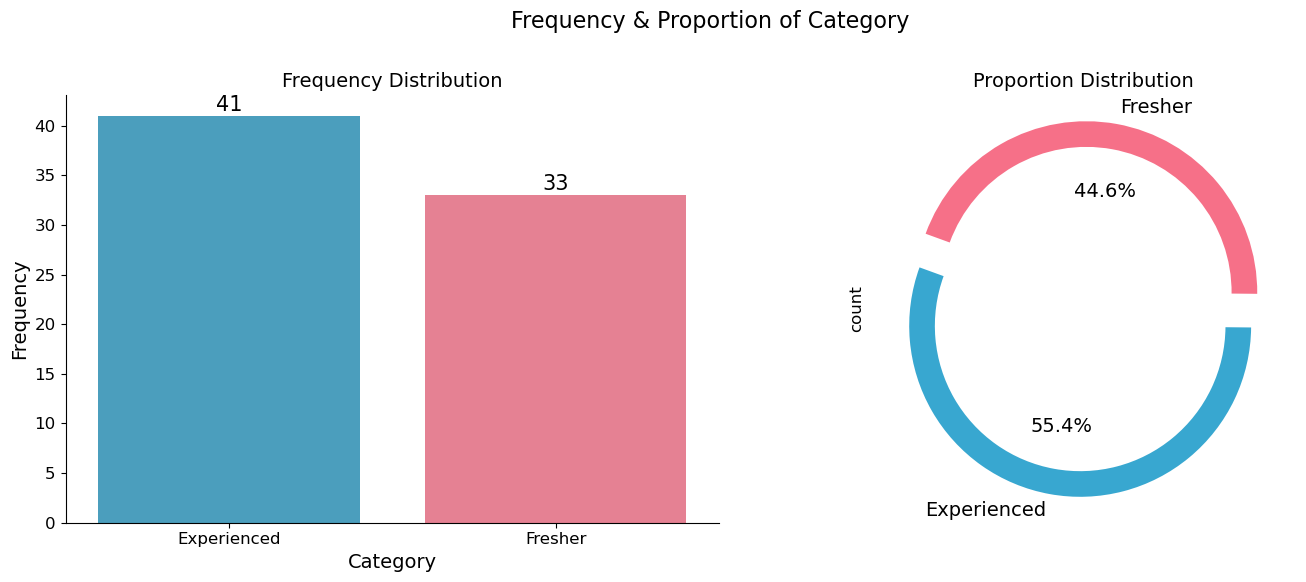

In [32]:
palette = ['#38A7D0', '#F67088']
fig = plt.figure(figsize = [15, 6])
plt.subplot(1, 2, 1)
ax = sns.countplot(x = 'Category', data = df, palette = palette)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                 ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')
plt.xlabel(xlabel = 'Category', size = 14)
plt.ylabel(ylabel = 'Frequency', size = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title(label = 'Frequency Distribution', size = 14)

plt.subplot(1, 2, 2)
space = np.ones(len(df.Category.unique()))/10
df['Category'].value_counts().plot(kind = 'pie', explode = space, fontsize = 14, autopct = '%3.1f%%', 
                                 wedgeprops = dict(width=0.15), startangle = 160, figsize = [15, 6], legend = False,
                                  colors=palette)
plt.title(label = 'Proportion Distribution', size = 14)
plt.tight_layout(pad = 3.0)
plt.suptitle(t = 'Frequency & Proportion of Category', y = 1.02, size = 16)
plt.show()

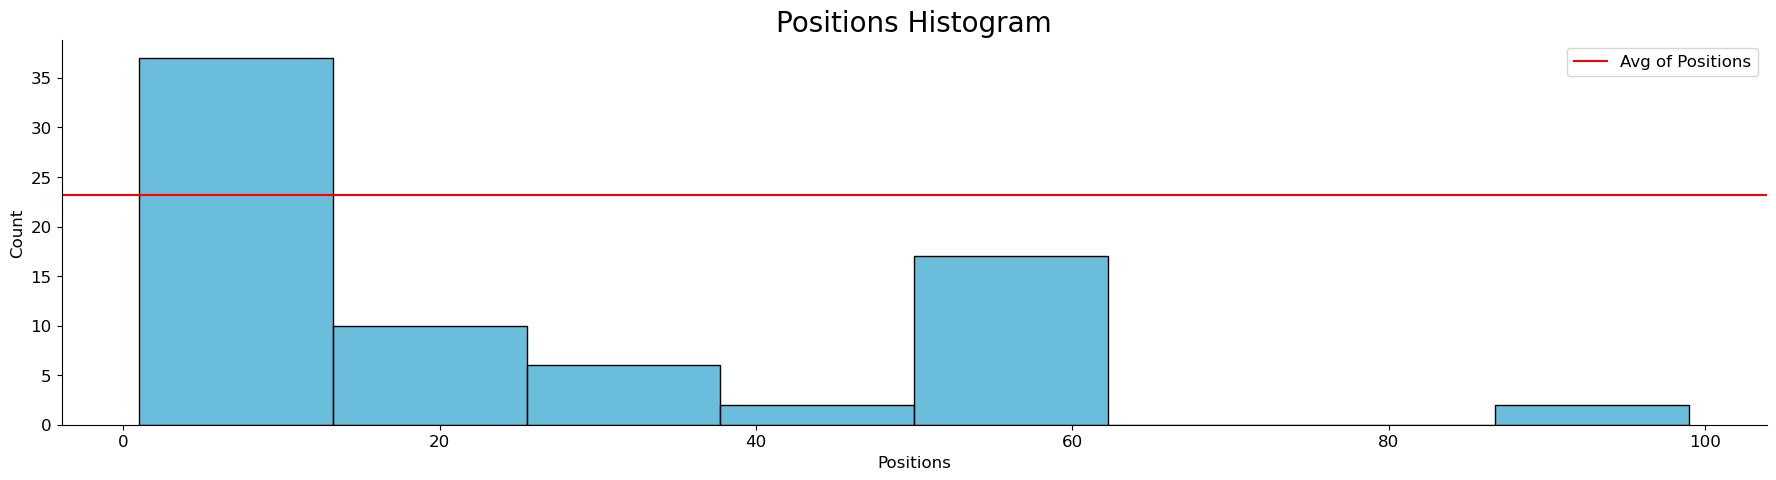

In [33]:
plt.figure(figsize=(22,5), dpi=100)
ax = sns.histplot(df['Positions'], color = palette[0])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Positions Histogram', fontsize=20)
plt.axhline(df.Positions.mean(), color='red')
plt.legend(['Avg of Positions'])
plt.show()

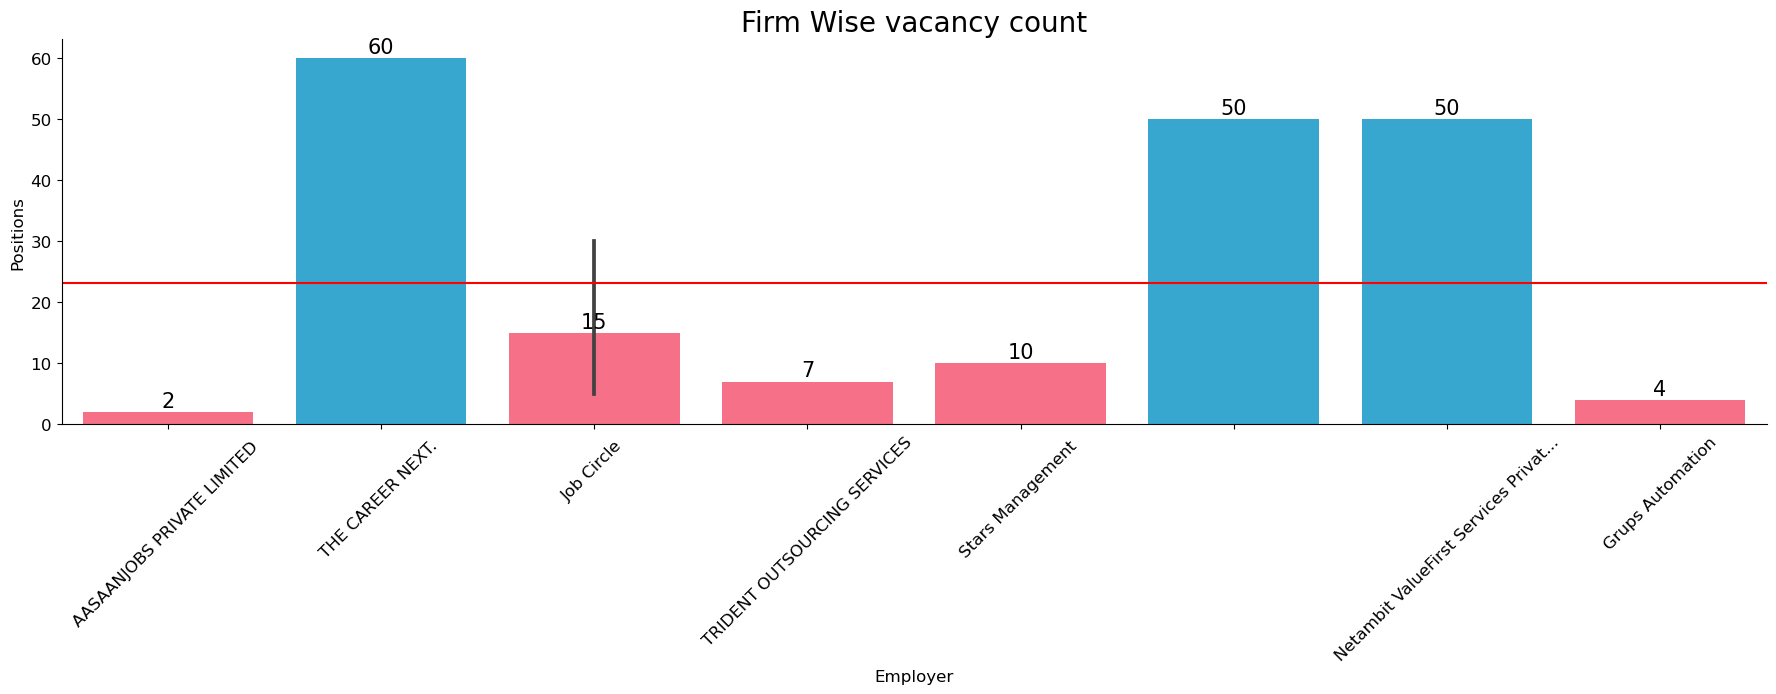

In [34]:
plt.figure(figsize=(22,5), dpi=100)
ax = sns.barplot(x=df['Employer'][:10], y=df['Positions'][:10])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Firm Wise vacancy count', fontsize=20)
plt.axhline(df.Positions.mean(), color='red')

#Annotating each bar
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                 ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')

#coloring each bar based on a condition if the bar value is greator or less than count of positions for a given firm 
for i in range(len(ax.patches)):
    #getting the count of each bar
    counts = [p.get_height() for p in ax.patches]
    #getting the colors based on the condition for each bar
    colors = ['#38A7D0' if j > df.Positions.mean() else '#F67088' for j in counts]
    #passing the color for each bar
    ax.patches[i].set_facecolor(colors[i])  
    
plt.xticks(rotation=45)
plt.show()


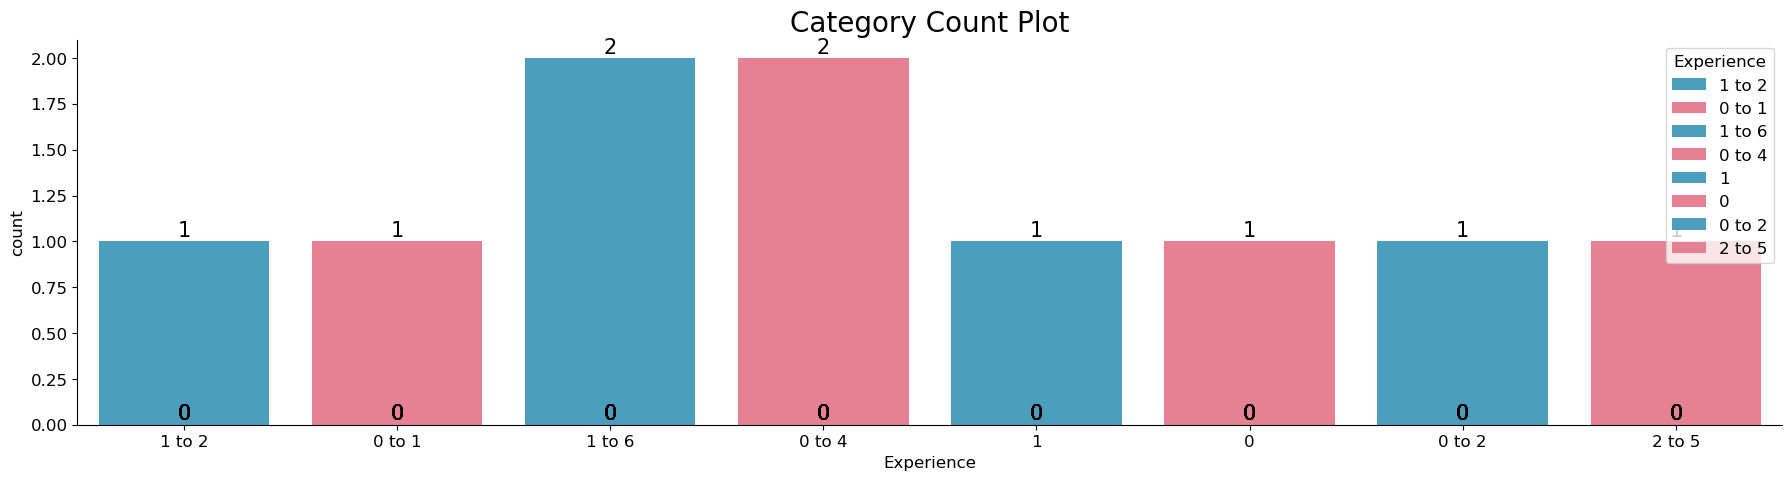

In [35]:
plt.figure(figsize=(22,5), dpi=100)
ax = sns.countplot(data =df,x=df['Experience'][:10], hue=df['Experience'][:10], dodge=False, palette=palette)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                 ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Category Count Plot', fontsize=20)
plt.show()